<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/main/Simple_SIR_ver17_3(16_00).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Version17.3: without "Create a Fully Connected Network

## Function definitions

In [2]:
def sir(G, beta = 1e-3, mu = 0.05, k = 10):
    #here's the modifications of the "test_ver1"
    'Number of nodes in the graph'
    N = G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    cum_total_inf = []
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    random.seed(0)

    'Selects the seed of the disease'
    seeds = random.sample(range(N), k) 
    for seed in seeds:
      current_state[seed] = 'I'
      future_state[seed] = 'I'
      inf_list.append(seed)


    'initilize prevalence and revocered list'
    prevalence = [len(inf_list)/N]
    recovered = [0]
    cum_positives = [k/N]


    loop = 0
    'start and continue whenever there s 1 infected'
    while(len(inf_list)>0):        
        
        daily_new_inf = 0
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible and not infected by another node in the future_state, try to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'; daily_new_inf += 1
                    else:
                        future_state[j] = 'S'
        
        cum_positives.append(cum_positives[-1]+daily_new_inf/N)  
        #loop +=1;
        #print("loop:", loop, cum_total_inf, cum_total_inf[-1], daily_new_inf/N)

        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'

        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))
 
    return prevalence, recovered, cum_positives

def plot_sir(G, beta = 1e-3, mu = 0.05, k = 10):
  # MF_SIR: beta = 1e-3, MF_SIR: mu = 0.05
  N = G.number_of_nodes()
  'plot ratio of daily infected and daily cumulative recovered'
  prevalence, recovered, cum_positives = sir(G, beta, mu, k)
  plt.plot(prevalence, label="Infected/N")
  plt.plot(recovered, label="Recovered/N")
  plt.plot(cum_positives, label="CD_Inf /N")


  'plot horizontal line to highlight the initial infected'
  plt.axhline(k/N, color = "r", ls="dashed", label = "Starting_Inf /N")
  locs, labels = plt.yticks()
  locs_yticks = np.array([])
  for i in range(len(locs)): 
      if locs[i] <= k/N < locs[i+1]:  
          locs_yticks  = np.concatenate((locs[1:i+1], [k/N], locs[i+1:-1])) #omit the 1st and last for better visualisation
  plt.yticks(locs_yticks, np.round(locs_yticks,3))


  'plot labels'
  plt.xlabel('Time', fontsize = 16)
  plt.ylabel('Indivs/N', fontsize = 16)
  plt.legend(loc="best");

'Net Infos'
def infos_sorted_nodes(G, num_nodes = False):
    'sort nodes by key = degree. printing order: node, adjacent nodes, degree'
    nodes = G.nodes()
    print("Sum_i k_i: ", np.sum([j for (i,j) in G.degree() ]), \
          " <k>: ", np.sum([j for (i,j) in G.degree() ]) / len(nodes), 
          " and <k>/N ", np.sum([j for (i,j) in G.degree() ]) / len(nodes)**2, end="\n\n" )
    
    'put adj_matrix into dic from better visualisation'
    adj_matrix =  nx.adjacency_matrix(G).todense()
    adj_dict = {i: np.nonzero(row)[1].tolist() for i,row in enumerate(adj_matrix)}

    infos = zip([x for x in nodes], [adj_dict[i] for i in range(len(nodes))], [G.degree(x) for x in nodes])
    inner_sorted_nodes = sorted( infos, key = lambda x: x[2])
    
    if num_nodes == True:  num_nodes = len(nodes)
    if num_nodes == False: num_nodes = 0
    for i in range(num_nodes):
      if i == 0: print("Triplets of (nodes, edges, degree) sorted by degree: \n")
      print( inner_sorted_nodes[i] )

def plot_G_degdist_adjmat_sir(G, figsize = (12,12), beta = 1e-3, mu = 0.05, k = 10, log = False):
  
  def rhu(n, decimals=0): #round_half_up
    import math
    multiplier = 10 ** decimals
    return int(math.floor(n*multiplier + 0.5) / multiplier)

  fig, axs = plt.subplots(2,2, figsize = figsize)
  nx.draw_circular(G, ax=axs[0,0], with_labels=True, font_size=12, node_size=5, width=.3)
  
  'set xticks to be centered'
  sorted_degree = np.sort([G.degree(n) for n in G.nodes()])

  'degree distribution + possonian distr'
  from scipy.stats import poisson
  bins = np.arange(sorted_degree[0]-1,sorted_degree[-1]+2)
  mean = rhu( np.sum([j for (i,j) in G.degree() ]) / G.number_of_nodes() )
  print("rounded degrees mean", mean)
  y = poisson.pmf(bins, mean)
  n, hist_bins, patches = axs[0,1].hist(sorted_degree, bins = bins, \
                                        log = log, density=0, color="green", ec="black", lw=1, align="left", label = "degrees distr")
  hist_mean = n[np.where(hist_bins == mean)]; pois_mean = poisson.pmf(mean, mean)
  'useful but deletable print'
  #print( "bins = bins", bins, "\nhist_bins", hist_bins, "\ny", y, "\nn", n, \
  #      "\npois mean", pois_mean , "hist_mean", hist_mean,  \
  #      "\nmean", mean, "\nhist_mean", hist_mean, "  poisson.pmf", poisson.pmf(int(mean),mean), )
  axs[0,1].plot(bins, y * hist_mean / pois_mean, "bo--", lw = 2, label = "poissonian distr")
  axs[0,1].set_xlim(bins[0],bins[-1]) 
  axs[0,1].legend(loc = "best")
  

  'plot adjiacency matrix'
  adj_matrix = nx.adjacency_matrix(G).todense()
  axs[1,0].matshow(adj_matrix, cmap=plt.cm.Greens)
  print("Adj_matrix is symmetric", np.allclose(adj_matrix, adj_matrix.T))

  'plot sir'
  plot_sir(G, beta, mu, k)



## Importation

In [3]:
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

np.set_printoptions(precision=4, suppress=True)

#make the axes white
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
        "axes.titlecolor":"k"}
plt.rcParams.update(params)

##CONNECTED_Watts-Strogatz Net!

This model works only if k = even, i.e. if k=odd then k-1 is choosen. So, k-1 neighbors are connected + I've choosen that if k_ws = float -> round_half_up(k_ws) = k_ws and let the watts-strogatz model go ahead. I "round_half_up" since, as for N = 15, k = N/2 = 8, in many cases it drives to a nearer pruning.

TODO: 
  * if pow_max +1 --> error of connectivity;
  * if num_iter == True and 1 is passed then 1=True

In [4]:
### DEFINITIONS CELL
def remove_loops_parallel_edges(G, remove_loops = True):
  full_ls = list((G.edges()))
  lpe = []
  for i in full_ls:
    full_ls.remove(i)
    for j in full_ls:
      if i == j: lpe.append(j); #print("i", i, "index", full_ls.index(i)+1, "j", j)
  if remove_loops == True:  
    for x in list(nx.selfloop_edges(G)): lpe.append(x)
    print("Parallel edges and loops removed!")
  return G.remove_edges_from(lpe)

def check_loops_parallel_edges(G):
  ls = list(G.edges())
  print("parallel edges", [i for i in ls for j in ls[ls.index(i)+1:] if i==j])
  print("loops", [(i,j) for (i,j) in set(G.edges()) if i == j])

k_ws for error comprehension 20
beta_eff 0.001 ; mu_eff: 0.05
rounded degrees mean 19
Adj_matrix is symmetric True


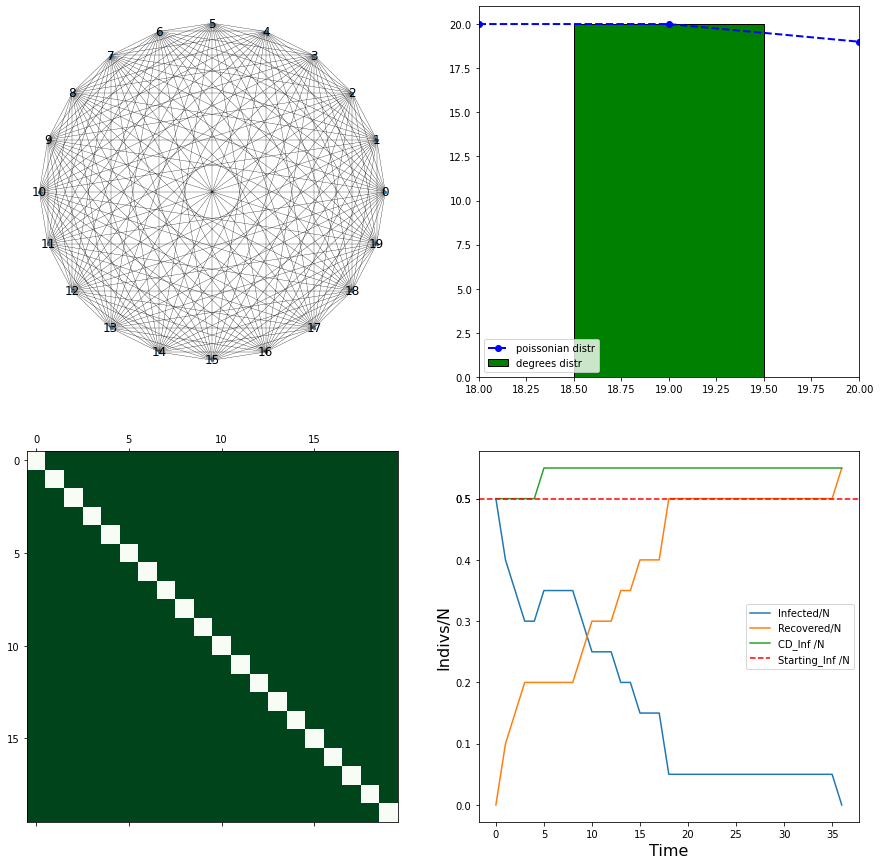

In [5]:
'rewire all the edges with a probability of p'
N = int(20); p_max = 0

'number of iterations, i.e. or max power or fixed by user'
def pow_max(N = N, num_iter = "all"):
  if num_iter == "all":
    'search the 2**pow_max'
    i = 0;
    while(N-2**i>0): i+=1
    return i-1
  return int(num_iter)

def rhu(n, decimals=0): #round_half_up
  import math
  multiplier = 10 ** decimals
  return math.floor(n*multiplier + 0.5) / multiplier

def ws_sir(N = N, k_ws = None, p = 0.1, infos = True):  
  'in this def: cut_factor = % of links remaining from the full net'
  'round_half_up k_ws for a better approximation of nx.c_w_s_graph+sir'


  if k_ws == None: k_ws = N
  k_ws = int(rhu(k_ws))
  cut_factor = k_ws / N #float
  'With p = 1 and <k>/N ~ 0, degree distr is sim to a Poissonian'
  print("k_ws for error comprehension", k_ws)
  G = nx.connected_watts_strogatz_graph( n = N, k = k_ws, p = p, seed = 1 ) #k is the number of near linked nodes
  #check_loops_parallel_edges(G)
  #if infos == True: infos_sorted_nodes(G, num_nodes = False)
  
  'set spreading parameters'
  beta_eff = 0.001/cut_factor; mu_eff = 0.05/cut_factor 
  #Thurner pmts: beta_eff = 0.1, mu = 0.16; k_ws = 3 vel 8
  #MF def: beta_eff, mu_eff = 0.001/cf, 0.05/cf or 0.16/cf ; cf = 1
  print("beta_eff %s ; mu_eff: %s" % (beta_eff, mu_eff))
  
  'plot all'
  plot_G_degdist_adjmat_sir(G, figsize=(15,15), beta = beta_eff, mu = mu_eff, log = False)    
  try:
    plt.savefig("WS_plots/SIR_N%s_k%s_p%s_beta%s_mu%s" % (N,k_ws,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")
  except:
    !mkdir WS_plots/
    plt.savefig("WS_plots/SIR_N%s_k%s_p%s_beta%s_mu%s" % (N,k_ws,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")


'excecute the code'
k_prog = [int(N/x) for x in \
          [2**i for i in range(0,pow_max(num_iter = 1))]] #if pow_max +1 --> error of connectivity
p_prog = np.linspace(0,p_max,int(p_max*10)+1)
for k_ws, p in product(k_prog,p_prog):  
  ws_sir(k_ws = k_ws, p = p)

In [6]:
from google.colab import files
#!rm -r /content/WS_plots/*.pdf
#!rm -rf WS_plots/
#!zip -r /content/WS_plots.zip /content/WS_plots
#files.download("/content/WS_plots.zip") 

## Configurational Model with poissonian degree: 
1) Question: 
  1. using this meth, loops and parallel edges are present leading to a adj_matrix not normalized to 1. Since neighbors are involved in sir and contagious is made by (fut = S, curr = S) - nodes, I may leave them, but there're not so in line of "social contacts". So, I prefer to remove them, but I loose a lot of precision if $D / N !<< 1$. <br>Ex., $D = 50 = N, \, <k> \sim 28$. For $N= 1000 \, \text{ and } D = 3 \textrm{ or } 8, <k> \textrm{is acceptable.}$
  2. To avoid the picking of $0$, choice on a poisson sequence

TODO: implement the idea of a pruning factor as in ws_sir

Degree sum: 3168 with seed: 123 numb of 0-degree nodes: 0

Network Created but w/o standard neighbors wiring!
parallel edges [(23, 293), (23, 293)]
loops [(602, 602), (2, 2)]
Parallel edges and loops removed!
Sum_i k_i:  3162  <k>:  3.162  and <k>/N  0.003162

beta_eff 0.2 ; mu_eff: 0.16
rounded degrees mean 3
Adj_matrix is symmetric True


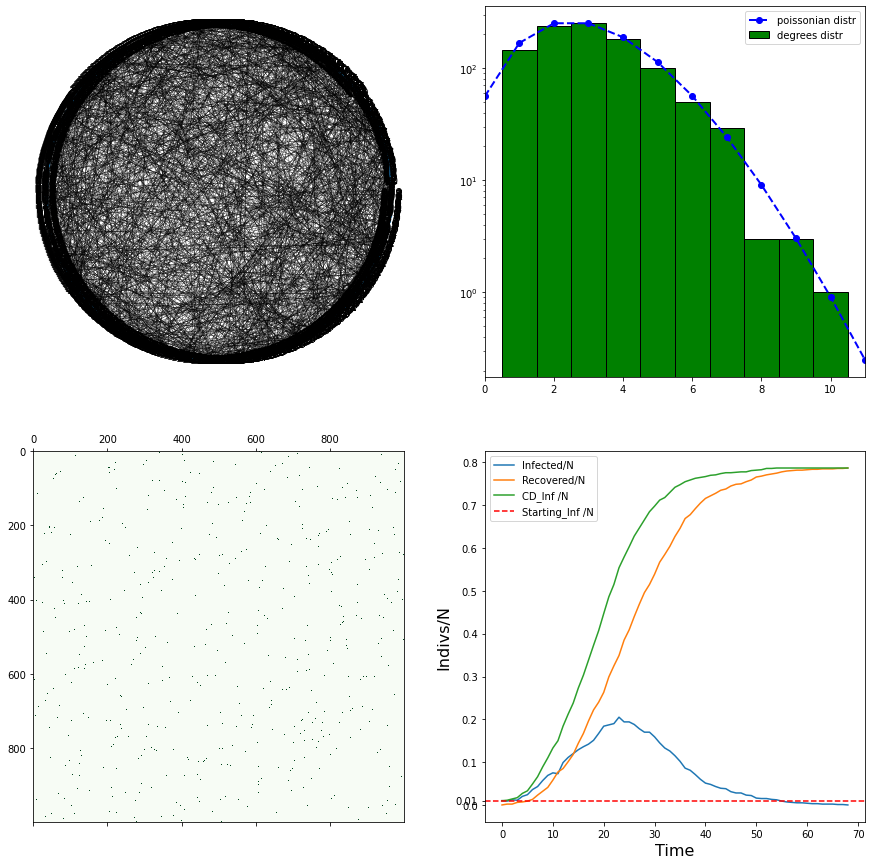

In [33]:
#from google.colab import files
#!rm -r /content/Config_plots/*.pdf

D = 3; seed=123; p = 0; N = int(1e3)

def config_pois_model(N = N, D = D, p = 0, seed = 123, visual = True):
  'Draw N degrees from a Poissonian sequence with lambda = D and length L'
  def pois_pos_degrees(D, N, L = int(2e3)):
    degs = np.random.poisson(lam = D, size = L)
    #print("len(Os) in deg", len([x for x in degs if x == 0])) 
    pos_degrees = np.random.choice([x for x in degs if x != 0], N)
    #print("len(Os) in pos_degrees", len([x for x in pos_degrees if x == 0]))
    return pos_degrees

  '''create a network with the node degrees drawn from a poissonian with even sum of degrees'''
  np.random.seed(seed)
  degrees = pois_pos_degrees(D,N) #for def of poissonian distr degrees are integers

  print("Degree sum:", np.sum(degrees), "with seed:", seed, "numb of 0-degree nodes:", len([x for x in degrees if x == 0]) )
  while(np.sum(degrees)%2 != 0): #i.e. sum is odd --> change seed
    seed+=1
    np.random.seed(seed)
    degrees = pois_pos_degrees(D,N)
    print("Degree sum:", np.sum(degrees), "with seed:", seed, )

  print("\nNetwork Created but w/o standard neighbors wiring!")
  '''create and remove loops since they apppears as neighbors of a node. Check it via print(list(G.neighbors(18))'''
  G = nx.configuration_model(degrees, seed = seed)

  'If D/N !<< 1, by removing loops and parallel edges, we lost degrees. Ex. with N = 50 = D, <k> = 28 != 49.8'
  check_loops_parallel_edges(G)
  remove_loops_parallel_edges(G)
  #check_loops_parallel_edges(G)

  infos_sorted_nodes(G)

  'plot G, degree distribution and the adiaciency matrix'
  cut_factor = 1
  global beta_eff, mu_eff
  beta_eff = 0.2/cut_factor; mu_eff = 0.16/cut_factor 
  #Thurner pmts: beta_eff = 0.1, mu = 0.16; k_ws = 3 vel 8
  #MF def: beta_eff, mu_eff = 0.001/cf, 0.05/cf or 0.16/cf ; cf = 1
  #Config_SIR def: D = 8, beta_eff, mu_eff = 0.1, 0.05
  print("beta_eff %s ; mu_eff: %s" % (beta_eff, mu_eff))
  if visual == True: plot_G_degdist_adjmat_sir(G, figsize=(15,15), beta = beta_eff, mu = mu_eff, log = True) 

  try:
      plt.savefig("Config_plots/Conf_SIR_N%s_D%s_p%s_beta%s_mu%s" % (N,D,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")
  except:
      !mkdir Config_plots
      plt.savefig("Config_plots/Config_SIR_N%s_D%s_p%s_beta%s_mu%s" % (N,D,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")

  return G

'''def:: "replace" existing edges, since built-in method only adds'''
def replace_edges_from(G,list_edges=[]):
    ebunch = [x for x in G.edges()]
    G.remove_edges_from(ebunch)
    if list_edges!=[]: return G.add_edges_from(list_edges)
    return G

G = config_pois_model()

In [18]:
infos_sorted_nodes(G, False)

'''def:: "replace" existing edges, since built-in method only adds'''
def replace_edges_from(G,list_edges=[]):
    ebunch = [x for x in G.edges()]
    G.remove_edges_from(ebunch)
    if list_edges!=[]: return G.add_edges_from(list_edges)
    return G

Sum_i k_i:  3162  <k>:  3.162  and <k>/N  0.003162



## NN_rewiring: Pb with D = 8

Degree sum: 3168 with seed: 123 numb of 0-degree nodes: 0

Network Created but w/o standard neighbors wiring!
parallel edges [(23, 293), (23, 293)]
loops [(602, 602), (2, 2)]
Parallel edges and loops removed!
Sum_i k_i:  3162  <k>:  3.162  and <k>/N  0.003162

beta_eff 0.01 ; mu_eff: 0.16
parallel edges []
loops [(66, 66), (729, 729), (554, 554), (747, 747), (875, 875), (239, 239), (108, 108), (207, 207), (602, 602), (935, 935), (26, 26), (794, 794), (672, 672), (213, 213), (111, 111), (642, 642), (320, 320), (608, 608), (772, 772), (22, 22), (749, 749), (895, 895), (163, 163), (177, 177), (396, 396), (59, 59), (574, 574), (55, 55), (262, 262), (921, 921), (511, 511), (799, 799), (630, 630), (324, 324), (318, 318), (922, 922), (310, 310), (853, 853), (506, 506), (57, 57), (498, 498), (817, 817), (501, 501), (728, 728), (229, 229), (466, 466), (415, 415), (797, 797), (197, 197), (434, 434), (494, 494), (347, 347), (834, 834), (182, 182), (950, 950), (281, 281), (919, 919), (392, 392), (

<Figure size 432x288 with 0 Axes>

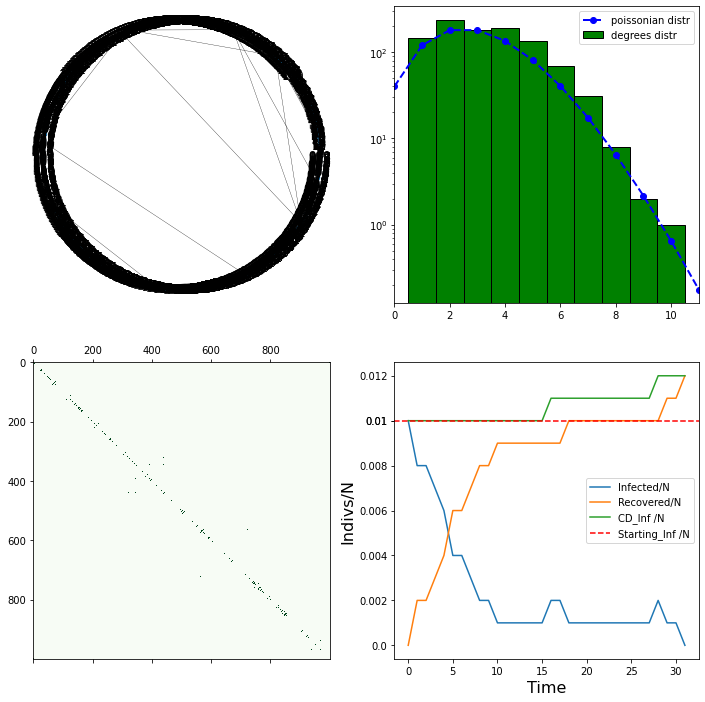

In [29]:
G = config_pois_model(visual = False)

verbose = False

def verboseprint(*args):
  if verbose == True:
      print(*args)
  elif verbose == False:
     None

'''for random rewiring with p'''
l_nodes = [x for x in G.nodes()]

edges = set() #avoid to put same link twice (+ unordered)
nodes_degree = {}

'list of the nodes sorted by their degree'
for node in G.nodes():
  nodes_degree[node] = G.degree(node)
sorted_nodes_degree = {k: v for k, v in sorted(nodes_degree.items(), key=lambda item: item[1])}
sorted_nodes = [node for node in sorted_nodes_degree.keys()]
verboseprint("There are the sorted_nodes", sorted_nodes) #, "\n", sorted_nodes_degree.values())

'cancel all the edges'
replace_edges_from(G)


'------ Start of Rewiring with NNR! ---------'
'''Hint: create edges rewiring from ascending degree'''
def get_var_name(my_name):
  varName = ""
  variables = dict(globals())
  for name in variables:
      if variables[name] is my_name:
          #verboseprint("v[n]", variables[name], "my_n", my_name)
          return name
def ls_nodes_remove(node): l_nodes.remove(node); sorted_nodes.remove(node)
def zero_deg_remove(node): 
  if nodes_degree[node] == 0 and node in l_nodes and node in sorted_nodes: ls_nodes_remove(node); verboseprint("\n", get_var_name(node), "is node", node, "geremoved via if deg == 0")

verboseprint("\nStart of the wiring:")
while( len(l_nodes) > 1 ):
  node = sorted_nodes[0]
  verboseprint("---------------------------")
  verboseprint("Wire node", node, " with degree", nodes_degree[node], \
        "\nto l_nodes left for rew:", l_nodes, "\nlen(nodes left)", len(l_nodes))
  
  L = len(l_nodes)
  #try:
  aa_attached = l_nodes[(l_nodes.index(node)+1)%L]; verboseprint("aa_attached is ", aa_attached)
  #except: verboseprint("error in the anti_anti_clock-wise attachment -- break"); break
  
  if node in l_nodes:
    'if degreees[node] > 1, forced-oscillation-wiring'
    for j in range(1,nodes_degree[node]//2+1): #neighbors attachment and no self-loops "1"
        if len(l_nodes) == 1: break
        verboseprint("entered for j:",j)
        idx = l_nodes.index(node)
        verboseprint("idx_node:", idx)
        a_attached = l_nodes[(idx+j)%L] #anticlockwise-linked node
        c_attached = l_nodes[(idx-j)%L]
        aa_attached = l_nodes[(idx-nodes_degree[node]//2+1)%L]
        verboseprint(node,a_attached); verboseprint(node,c_attached);
        if node != a_attached: edges.add((node,a_attached)); nodes_degree[a_attached]-=1; \
        verboseprint("deg[%s] = %s" % (a_attached, nodes_degree[a_attached]))
        if node != c_attached: edges.add((node,c_attached)); nodes_degree[c_attached]-=1; \
        verboseprint("deg[%s] = %s"%(c_attached,nodes_degree[c_attached]))

        '''remove node whenever its degree is = 0:'''
        zero_deg_remove(a_attached);
        zero_deg_remove(c_attached);

    if len(l_nodes) == 1: break       
    '''if nodes_degree[i] is odd  and the aa_attached, present in l_nodes, has a stub avaible, then, +1 anticlock-wise'''
    if nodes_degree[node] % 2 != 0 and nodes_degree[aa_attached] != 0 : edges.add((node, aa_attached)); nodes_degree[aa_attached]-=1; \
                            verboseprint("edge with aa added: ", node, aa_attached, "and deg_aa_att[%s] = %s"%(aa_attached,nodes_degree[aa_attached]))
    
    'aa_attached == 0 should not raise error since it should be always present in l_n and s_n'
    if nodes_degree[aa_attached] == 0: ls_nodes_remove(aa_attached); verboseprint("\naa_attached node", aa_attached, "  removed via if deg == 0")
    if node in l_nodes: ls_nodes_remove(node);  verboseprint(node, "is removed via last if statement")
    if len(l_nodes)==1: verboseprint("I will stop here"); break

verboseprint("End of wiring")

replace_edges_from(G, edges)

check_loops_parallel_edges(G)
infos_sorted_nodes(G, num_nodes=False)


plot_G_degdist_adjmat_sir(G, beta = beta_eff, mu = mu_eff, log = True)


try:
      plt.savefig("Config_plots/NNR_Conf_SIR_N%s_D%s_p%s_beta%s_mu%s" % (N,D,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")
except:
      !mkdir Config_plots
      plt.savefig("Config_plots/NNR_Config_SIR_N%s_D%s_p%s_beta%s_mu%s" % (N,D,p, rhu(beta_eff,3), rhu(mu_eff,3)) + ".pdf")



In [34]:
from google.colab import files
#!rm -r /content/WS_plots/*.pdf
#!rm -rf WS_plots/
!zip -r /content/Config_plots.zip /content/Config_plots
files.download("/content/Config_plots.zip") 

updating: content/Config_plots/ (stored 0%)
updating: content/Config_plots/Conf_SIR_N1000_D3_p0_beta0.01_mu0.16.pdf (deflated 8%)
updating: content/Config_plots/NNR_Conf_SIR_N1000_D3_p0_beta0.1_mu0.16.pdf (deflated 8%)
updating: content/Config_plots/Conf_SIR_N1000_D3_p0_beta0.2_mu0.16.pdf (deflated 7%)
updating: content/Config_plots/.ipynb_checkpoints/ (stored 0%)
updating: content/Config_plots/Conf_SIR_N1000_D3_p0_beta0.1_mu0.16.pdf (deflated 7%)
updating: content/Config_plots/NNR_Conf_SIR_N1000_D3_p0_beta0.2_mu0.16.pdf (deflated 8%)
updating: content/Config_plots/NNR_Conf_SIR_N1000_D3_p0_beta0.01_mu0.16.pdf (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Old version of the above cell

In [ ]:
'''Nearest-Neighbors Rewiring (NNR) by ascending degree order'''
nodes_rew = [x for x in G.nodes()]

'''for random rewiring with p'''
l_nodes = nodes_rew.copy() 


edges = set() #avoid to put same link twice (+ unordered)
nodes_degree = {}

'list of the nodes sorted by their degree'
for node in G.nodes():
  nodes_degree[node] = G.degree(node)
sorted_nodes_degree = {k: v for k, v in sorted(nodes_degree.items(), key=lambda item: item[1])}
sorted_nodes = [node for node in sorted_nodes_degree.keys()]
print("There are the sorted_nodes", sorted_nodes) #, "\n", sorted_nodes_degree.values())

'cancel all the edges'
replace_edges_from(G)

print("\nStart of the rewiring:")
for node in sorted_nodes:
  print("---------------------------")
  print("wiring node", node, " with degree", nodes_degree[node], "\nto l_nodes left for rew:", l_nodes, "\nlen(nodes left)", len(l_nodes))
  #print(len(l_nodes))
  L = len(l_nodes)
  try:
    aa_attached = l_nodes[(l_nodes.index(node)+1)%L]; print("aa_attached is ", aa_attached)
    if aa_attached == node: aa_attached = l_nodes[1]; print("aa_attached has been changed from %s to %s"%(l_nodes[0], l_nodes[1]))
  except: print("l_nodes:", l_nodes, "was 0 after",node, "So, break it" ); break
  
  if node in l_nodes:
    '''create edges rewiring from ascending degree'''

    'if degreees[node] > 1, forced-oscillation-wiring'
    for j in range(1,nodes_degree[node]//2+1): #neighbors attachment and no self-loops "1"
        
        print("entered for j:",j)
        idx = l_nodes.index(node)
        print("idx_node:", idx)
        a_attached = l_nodes[(idx+j)%L] #anticlockwise-linked node
        c_attached = l_nodes[(idx-j)%L]
        aa_attached = l_nodes[(idx-nodes_degree[node]//2+1)%L]
        #print(node,a_attached); print(node,c_attached);
        if node != a_attached: edges.add((node,a_attached)); nodes_degree[a_attached]-=1; \
        #print("deg[%s] = %s" % (a_attached, nodes_degree[a_attached]))
        if node != c_attached: edges.add((node,c_attached)); nodes_degree[c_attached]-=1; \
        #print("deg[%s] = %s"%(c_attached,nodes_degree[c_attached]))

        '''remove node whenever its degree is = 0:'''
        try: 
          if nodes_degree[a_attached] == 0: l_nodes.remove(a_attached);
        except: 
          print("error for a_att:", a_attached)
        try: 
          if nodes_degree[c_attached] == 0: l_nodes.remove(c_attached);
        except: 
          print("error for c_att:", c_attached)
          
    '''if nodes_degree[i] is odd  and the aa_attached, present in l_nodes, has a stub avaible, then, +1 anticlock-wise'''
    if nodes_degree[node] % 2 != 0 and nodes_degree[aa_attached] != 0 : edges.add((node, aa_attached)); nodes_degree[aa_attached]-=1; \
                            print("edge added: ", node, aa_attached); print("deg[%s] = %s"%(aa_attached,nodes_degree[aa_attached]))
    
    'aa_attached == 0 shold be always present'
    if nodes_degree[aa_attached] == 0: l_nodes.remove(aa_attached); print("\naa_attached node", aa_attached, "  removed via if deg == 0")
    if node in l_nodes: l_nodes.remove(node);  print(node, "is removed via last if statement")

  if len(l_nodes)==1: print("stop!"); break

print(G.edges())
replace_edges_from(G, edges)

check_loops_parallel_edges(G)
infos_sorted_nodes(G)

plot_G_degdist_adjmat_sir(G, log = True)

NB: seed = 125; Taken comments on plot sir to cure the warning